In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [2]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path="checkpoint.pt"):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

In [3]:
def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['batch_idx']


In [4]:
from torch.utils.data import DataLoader, Dataset
import torch

data = torch.load(
    "/kaggle/input/hindi-sentiment-data/tokenized_with_labels.pt",
    weights_only=False
)


In [5]:
# build a map from original → contiguous
# label_map = {lab: i for i, lab in enumerate(sorted(unique_labels.tolist()))}
label_map = {0: 0, 1: 1, 3: 2}

# Apply it to your dataset
for item in data:
    item["labels"] = torch.tensor(label_map[item["labels"].item()], dtype=torch.long)

# Now the max label is 2, so
output_dim = len(label_map)  # = 3


In [6]:

# 2. Basic checks
print("Length of dataset:", len(data))
print("Type of first item:", type(data[0]))

# 3. Print the first item (sample)
print("First item:", data[0])

Length of dataset: 31726
Type of first item: <class 'dict'>
First item: {'input_ids': tensor([     2,   4384,   4285,   9545,     12,   3496,   1134, 109832,    477,
         26697, 134087,   7425,   2700,   4384,     31,   8351,     37,   2863,
          6511,  38637,   1883,   4285,   1640,   3496,   1134, 109832,     15,
         22186,   6169,    494,  22186,      3,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,   

In [7]:
from torch.utils.data import Dataset, DataLoader
import torch

# Load tokenized data
# tokenized_dataset = torch.load("/content/drive/MyDrive/sentiment_analysis/dataset/tokenized_by_indicbert_data_combined.pt")
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data  # list of dicts

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            'input_ids': item['input_ids'],
            'attention_mask': item['attention_mask'],
            'label': item['labels']
        }


dataset = MyDataset(data)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [8]:
from torch.utils.data import random_split

# 80% training, 20% validation
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [10]:
def save_checkpoint(model, optimizer, epoch, batch_idx, path="checkpoint.pt"):
    torch.save({
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

In [11]:
def load_checkpoint(model, optimizer, path="checkpoint.pt"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['batch_idx']

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
import time


In [18]:

# Config
# model_name = "ai4bharat/indic-bert-v2"
model_name = "ai4bharat/indic-bert"

num_epochs = 20
batch_size = 64
patience = 3
learning_rate = 2e-5
output_dim = 3


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [20]:
# In terminal or notebook
!huggingface-cli search ai4bharat --author ai4bharat


usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,auth,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag,version,upload-large-folder}: invalid choice: 'search' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'auth', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag', 'version', 'upload-large-folder')


In [21]:
# Model
class IndicBERTClassifier(nn.Module):
    def __init__(self, output_dim, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        return self.classifier(dropped)

model = IndicBERTClassifier(output_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

2025-07-06 07:26:46.325781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751786806.499197      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751786806.546076      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [22]:

# Training and evaluation functions
def train(model, dataloader):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)


model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

In [23]:
def evaluate(model, dataloader):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * input_ids.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(dataloader.dataset), total_correct / len(dataloader.dataset)


In [24]:
start_epoch = 0
start_batch_idx = 0
checkpoint_path = "checkpoint.pt"

# Load checkpoint if exists
import os
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    start_epoch, _ = load_checkpoint(model, optimizer, checkpoint_path)
    print(f" Resuming from epoch {start_epoch + 1}")
else:
    print("Starting training from scratch")

# Training loop
best_val_loss = float("inf")
epochs_no_improve = 0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save current checkpoint
    save_checkpoint(model, optimizer, epoch, 0, path=checkpoint_path)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

print(f"\nTraining complete in {(time.time() - start_time):.2f} seconds.")
# model.load_state_dict(torch.load("best_model.pt"))


Starting training from scratch

Epoch 1/20
Train Loss: 0.9670 | Train Acc: 0.5173
Val   Loss: 0.8554 | Val   Acc: 0.6111

Epoch 2/20
Train Loss: 0.7986 | Train Acc: 0.6476
Val   Loss: 0.7836 | Val   Acc: 0.6558

Epoch 3/20
Train Loss: 0.7142 | Train Acc: 0.6951
Val   Loss: 0.7536 | Val   Acc: 0.6741

Epoch 4/20
Train Loss: 0.6541 | Train Acc: 0.7282
Val   Loss: 0.7491 | Val   Acc: 0.6787

Epoch 5/20
Train Loss: 0.5845 | Train Acc: 0.7666
Val   Loss: 0.7918 | Val   Acc: 0.6777

Epoch 6/20
Train Loss: 0.5064 | Train Acc: 0.8000
Val   Loss: 0.7998 | Val   Acc: 0.6703

Epoch 7/20
Train Loss: 0.4268 | Train Acc: 0.8383
Val   Loss: 0.8998 | Val   Acc: 0.6574
Early stopping triggered.

Training complete in 4271.01 seconds.


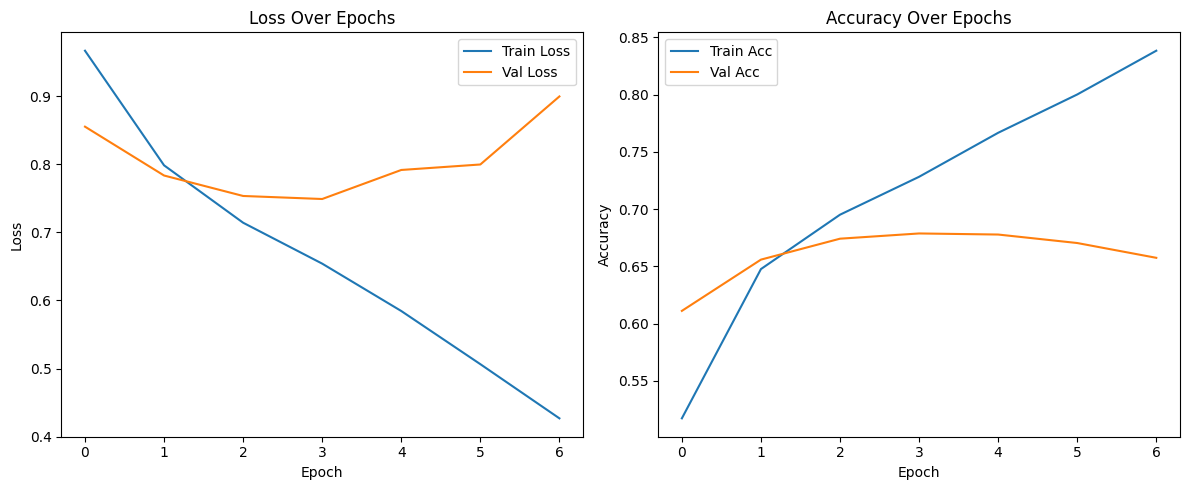

In [25]:

# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Plot losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model & tokenizer
model_name = "ai4bharat/indic-bert"  # Replace if you used another model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Label mapping
label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Model definition (same as training)
class IndicBERTClassifier(nn.Module):
    def __init__(self, output_dim, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0]
        dropped = self.dropout(cls_token)
        return self.classifier(dropped)

# Load model
model = IndicBERTClassifier(output_dim=3)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

# 🔍 Prediction function
def predict_sentiment(sentence):
    tokens = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)
        sentiment = label_map[predicted_class.item()]
        confidence_score = confidence.item()
    
    return sentiment, confidence_score

# 🧪 Example
sentence = "तुम्हारी कड़ी मेहनत सफल रही।"
sentiment, confidence = predict_sentiment(sentence)

print(f" Sentence: {sentence}")
print(f" Predicted Sentiment: {sentiment}")
print(f" Confidence: {confidence:.4f}")


📝 Sentence: तुम्हारी कड़ी मेहनत सफल रही।
🔍 Predicted Sentiment: positive
📊 Confidence: 0.9366
